# 01 - The Machine Learning Landscape

This notebook contains the code to predict the OECD life satisfaction index based on the IMF GDP per capita for a number of countries. 

Helps introduce various concepts in machine learning such as:
- Training a model
- Overfitting
- Regularization

## Notebook pre-setting

### Get pre-requisite liberies version

In [2]:
import sys
assert sys.version_info >= (3, 5)

In [3]:
print(sys.version_info)

sys.version_info(major=3, minor=8, micro=11, releaselevel='final', serial=0)


In [4]:
import sklearn
assert sklearn.__version__ >= "0.20"

In [5]:
print(sklearn.__version__)

0.24.2


### Define dataset path

In [12]:
import os
datapath = os.path.join("..", "datasets", "lifesat", "")
datapath

'..\\datasets\\lifesat\\'

### Plot pretty figures

In [8]:
%matplotlib inline
import matplotlib as mpl
mpl.rc("axes", labelsize=14)
mpl.rc("xtick", labelsize=12)
mpl.rc("ytick", labelsize=12)

### Helper function to prepare the data

In [20]:
def prepare_country_stats(oecd_bli, gdp_per_capita):
    # Get only rows with total life satisfaction index
    oecd_bli = oecd_bli[oecd_bli["INEQUALITY"] == "TOT"]
    oecd_bli = oecd_bli.pivot(index="Country", columns="Indicator", values="Value")
    gdp_per_capita.rename(columns={"2015": "GDP per capita"}, inplace=True)
    gdp_per_capita.set_index("Country", inplace=True)
    full_country_stats = pd.merge(left=oecd_bli, right=gdp_per_capita, 
                                  left_index=True, right_index=True)
    full_country_stats.sort_values(by="GDP per capita", inplace=True)
    remove_indices = [0, 1, 6, 8, 33, 34, 35]
    keep_indices = list(set(range(36)) - set(remove_indices))
    return full_country_stats[["GDP per capita", "Life satisfaction"]].iloc[keep_indices]

### Helper function to save figures

In [64]:
CHAPTER_ID = "fundamentals"
IMAGES_PATH = os.path.join("..", "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Import libraries

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.linear_model

## Machine Learning Pipeline

### Load the data

In [23]:
oecd_bli = pd.read_csv(datapath + "oecd_bli_2015.csv", thousands=",")
gdp_per_capita = pd.read_csv(datapath + "gdp_per_capita.csv", thousands=",", delimiter="\t", 
                             encoding="latin1", na_values="n/a")

In [24]:
oecd_bli

,LOCATION,Country,INDICATOR,Indicator,MEASURE,Measure,INEQUALITY,Inequality,Unit Code,Unit,PowerCode Code,PowerCode,Reference Period Code,Reference Period,Value,Flag Codes,Flags
0,AUS,Australia,HO_BASE,Dwellings without basic facilities,L,Value,TOT,Total,PC,Percentage,0,units,NaN,NaN,1.10,E,Estimated value
1,AUT,Austria,HO_BASE,Dwellings without basic facilities,L,Value,TOT,Total,PC,Percentage,0,units,NaN,NaN,1.00,NaN,NaN
2,BEL,Belgium,HO_BASE,Dwellings without basic facilities,L,Value,TOT,Total,PC,Percentage,0,units,NaN,NaN,2.00,NaN,NaN
3,CAN,Canada,HO_BASE,Dwellings without basic facilities,L,Value,TOT,Total,PC,Percentage,0,units,NaN,NaN,0.20,NaN,NaN
4,CZE,Czech Republic,HO_BASE,Dwellings without basic facilities,L,Value,TOT,Total,PC,Percentage,0,units,NaN,NaN,0.90,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3287,EST,Estonia,WL_TNOW,Time devoted to leisure and personal care,L,Value,WMN,Women,HOUR,Hours,0,units,NaN,NaN,14.43,NaN,NaN
3288,ISR,Israel,WL_TNOW,Time devoted to leisure and personal care,L,Value,WMN,Women,HOUR,Hours,0,units,NaN,NaN,14.24,E,Estimated value
3289,RUS,Russia,WL_TNOW,Time devoted to leisure and personal care,L,Value,WMN,Women,HOUR,Hours,0,units,NaN,NaN,14.75,E,Estimated value
3290,SVN,Slovenia,WL_TNOW,Time devoted to leisure and personal care,L,Value,WMN,Women,HOUR,Hours,0,units,NaN,NaN,14.12,NaN,NaN


In [25]:
gdp_per_capita

,Country,Subject Descriptor,Units,Scale,Country/Series-specific Notes,2015,Estimates Start After
0,Afghanistan,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",599.994,2013.0
1,Albania,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",3995.383,2010.0
2,Algeria,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",4318.135,2014.0
3,Angola,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",4100.315,2014.0
4,Antigua and Barbuda,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",14414.302,2011.0
...,...,...,...,...,...,...,...
185,Vietnam,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",2088.344,2012.0
186,Yemen,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",1302.940,2008.0
187,Zambia,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",1350.151,2010.0
188,Zimbabwe,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",1064.350,2012.0


### Prepare the data

In [18]:
set(oecd_bli['Indicator'])

{'Air pollution',
 'Assault rate',
 'Consultation on rule-making',
 'Dwellings without basic facilities',
 'Educational attainment',
 'Employees working very long hours',
 'Employment rate',
 'Homicide rate',
 'Household net adjusted disposable income',
 'Household net financial wealth',
 'Housing expenditure',
 'Job security',
 'Life expectancy',
 'Life satisfaction',
 'Long-term unemployment rate',
 'Personal earnings',
 'Quality of support network',
 'Rooms per person',
 'Self-reported health',
 'Student skills',
 'Time devoted to leisure and personal care',
 'Voter turnout',
 'Water quality',
 'Years in education'}

In [17]:
oecd_bli[oecd_bli["INEQUALITY"]=="TOT"].pivot(index="Country", columns="Indicator", values="Value")

Indicator,Air pollution,Assault rate,Consultation on rule-making,Dwellings without basic facilities,Educational attainment,Employees working very long hours,Employment rate,Homicide rate,Household net adjusted disposable income,Household net financial wealth,...,Long-term unemployment rate,Personal earnings,Quality of support network,Rooms per person,Self-reported health,Student skills,Time devoted to leisure and personal care,Voter turnout,Water quality,Years in education
Country,,,,,,,,,,,,,,,,,,,,,
Australia,13.0,2.1,10.5,1.1,76.0,14.02,72.0,0.8,31588.0,47657.0,...,1.08,50449.0,92.0,2.3,85.0,512.0,14.41,93.0,91.0,19.4
Austria,27.0,3.4,7.1,1.0,83.0,7.61,72.0,0.4,31173.0,49887.0,...,1.19,45199.0,89.0,1.6,69.0,500.0,14.46,75.0,94.0,17.0
Belgium,21.0,6.6,4.5,2.0,72.0,4.57,62.0,1.1,28307.0,83876.0,...,3.88,48082.0,94.0,2.2,74.0,509.0,15.71,89.0,87.0,18.9
Brazil,18.0,7.9,4.0,6.7,45.0,10.41,67.0,25.5,11664.0,6844.0,...,1.97,17177.0,90.0,1.6,69.0,402.0,14.97,79.0,72.0,16.3
Canada,15.0,1.3,10.5,0.2,89.0,3.94,72.0,1.5,29365.0,67913.0,...,0.90,46911.0,92.0,2.5,89.0,522.0,14.25,61.0,91.0,17.2
Chile,46.0,6.9,2.0,9.4,57.0,15.42,62.0,4.4,14533.0,17733.0,...,1.59,22101.0,86.0,1.2,59.0,436.0,14.41,49.0,73.0,16.5
Czech Republic,16.0,2.8,6.8,0.9,92.0,6.98,68.0,0.8,18404.0,17299.0,...,3.12,20338.0,85.0,1.4,60.0,500.0,14.98,59.0,85.0,18.1
Denmark,15.0,3.9,7.0,0.9,78.0,2.03,73.0,0.3,26491.0,44488.0,...,1.78,48347.0,95.0,1.9,72.0,498.0,16.06,88.0,94.0,19.4
Estonia,9.0,5.5,3.3,8.1,90.0,3.30,68.0,4.8,15167.0,7680.0,...,3.82,18944.0,89.0,1.5,54.0,526.0,14.90,64.0,79.0,17.5


In [22]:
gdp_per_capita.columns

Index(['Subject Descriptor', 'Units', 'Scale', 'Country/Series-specific Notes',
       'GDP per capita', 'Estimates Start After'],
      dtype='object')

In [26]:
country_stats = prepare_country_stats(oecd_bli, gdp_per_capita)

In [27]:
country_stats

,GDP per capita,Life satisfaction
Country,,
Russia,9054.914,6.0
Turkey,9437.372,5.6
Hungary,12239.894,4.9
Poland,12495.334,5.8
Slovak Republic,15991.736,6.1
Estonia,17288.083,5.6
Greece,18064.288,4.8
Portugal,19121.592,5.1
Slovenia,20732.482,5.7


In [28]:
X = np.c_[country_stats["GDP per capita"]]
y = np.c_[country_stats["Life satisfaction"]]

In [29]:
X

array([[ 9054.914],
       [ 9437.372],
       [12239.894],
       [12495.334],
       [15991.736],
       [17288.083],
       [18064.288],
       [19121.592],
       [20732.482],
       [25864.721],
       [27195.197],
       [29866.581],
       [32485.545],
       [35343.336],
       [37044.891],
       [37675.006],
       [40106.632],
       [40996.511],
       [41973.988],
       [43331.961],
       [43603.115],
       [43724.031],
       [43770.688],
       [49866.266],
       [50854.583],
       [50961.865],
       [51350.744],
       [52114.165],
       [55805.204]])

In [31]:
country_stats["GDP per capita"].to_numpy()

array([ 9054.914,  9437.372, 12239.894, 12495.334, 15991.736, 17288.083,
       18064.288, 19121.592, 20732.482, 25864.721, 27195.197, 29866.581,
       32485.545, 35343.336, 37044.891, 37675.006, 40106.632, 40996.511,
       41973.988, 43331.961, 43603.115, 43724.031, 43770.688, 49866.266,
       50854.583, 50961.865, 51350.744, 52114.165, 55805.204])

### Visualize data

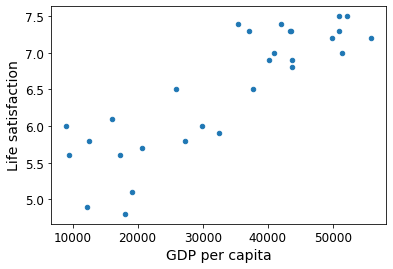

In [32]:
country_stats.plot(kind="scatter", x="GDP per capita", y="Life satisfaction")
plt.show()

### Train a linear model and predit 

In [35]:
model = sklearn.linear_model.LinearRegression()
model.fit(X, y)

# Make a prediction for Cyprus
X_new = [[22587]] # Cyprus' GDP per capita
print(model.predict(X_new))

[[5.96242338]]


### Replace model with K-Nearest Neighbors with k=3

In [36]:
import sklearn.neighbors
model1 = sklearn.neighbors.KNeighborsRegressor(n_neighbors=3)

model1.fit(X, y)

print(model1.predict(X_new))

[[5.76666667]]


## Bloopers

### Load and prepare OECD data

In [43]:
oecd_bli = pd.read_csv(datapath + "oecd_bli_2015.csv", thousands=",")
oecd_bli = oecd_bli[oecd_bli["INEQUALITY"] == "TOT"]
oecd_bli = oecd_bli.pivot(index="Country", columns="Indicator", values="Value")
oecd_bli.head(10)

Indicator,Air pollution,Assault rate,Consultation on rule-making,Dwellings without basic facilities,Educational attainment,Employees working very long hours,Employment rate,Homicide rate,Household net adjusted disposable income,Household net financial wealth,...,Long-term unemployment rate,Personal earnings,Quality of support network,Rooms per person,Self-reported health,Student skills,Time devoted to leisure and personal care,Voter turnout,Water quality,Years in education
Country,,,,,,,,,,,,,,,,,,,,,
Australia,13.0,2.1,10.5,1.1,76.0,14.02,72.0,0.8,31588.0,47657.0,...,1.08,50449.0,92.0,2.3,85.0,512.0,14.41,93.0,91.0,19.4
Austria,27.0,3.4,7.1,1.0,83.0,7.61,72.0,0.4,31173.0,49887.0,...,1.19,45199.0,89.0,1.6,69.0,500.0,14.46,75.0,94.0,17.0
Belgium,21.0,6.6,4.5,2.0,72.0,4.57,62.0,1.1,28307.0,83876.0,...,3.88,48082.0,94.0,2.2,74.0,509.0,15.71,89.0,87.0,18.9
Brazil,18.0,7.9,4.0,6.7,45.0,10.41,67.0,25.5,11664.0,6844.0,...,1.97,17177.0,90.0,1.6,69.0,402.0,14.97,79.0,72.0,16.3
Canada,15.0,1.3,10.5,0.2,89.0,3.94,72.0,1.5,29365.0,67913.0,...,0.90,46911.0,92.0,2.5,89.0,522.0,14.25,61.0,91.0,17.2
Chile,46.0,6.9,2.0,9.4,57.0,15.42,62.0,4.4,14533.0,17733.0,...,1.59,22101.0,86.0,1.2,59.0,436.0,14.41,49.0,73.0,16.5
Czech Republic,16.0,2.8,6.8,0.9,92.0,6.98,68.0,0.8,18404.0,17299.0,...,3.12,20338.0,85.0,1.4,60.0,500.0,14.98,59.0,85.0,18.1
Denmark,15.0,3.9,7.0,0.9,78.0,2.03,73.0,0.3,26491.0,44488.0,...,1.78,48347.0,95.0,1.9,72.0,498.0,16.06,88.0,94.0,19.4
Estonia,9.0,5.5,3.3,8.1,90.0,3.30,68.0,4.8,15167.0,7680.0,...,3.82,18944.0,89.0,1.5,54.0,526.0,14.90,64.0,79.0,17.5


`pandas.DataFrame.pivot()` only works if the index contains unique entries

### Load and prepare GDP per capita data

In [50]:
gdp_per_capita = pd.read_csv(datapath + "gdp_per_capita.csv", thousands=",", delimiter="\t", 
                             encoding="latin1", na_values="n/a")
gdp_per_capita.rename(columns={"2015": "GDP per capita"}, inplace=True)
gdp_per_capita.set_index("Country", inplace=True)
gdp_per_capita.head(10)

,Subject Descriptor,Units,Scale,Country/Series-specific Notes,GDP per capita,Estimates Start After
Country,,,,,,
Afghanistan,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",599.994,2013.0
Albania,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",3995.383,2010.0
Algeria,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",4318.135,2014.0
Angola,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",4100.315,2014.0
Antigua and Barbuda,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",14414.302,2011.0
Argentina,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",13588.846,2013.0
Armenia,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",3534.860,2014.0
Australia,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",50961.865,2014.0
Austria,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",43724.031,2015.0


In [51]:
full_country_stats = pd.merge(left=oecd_bli, right=gdp_per_capita, left_index=True, right_index=True)
full_country_stats

,Air pollution,Assault rate,Consultation on rule-making,Dwellings without basic facilities,Educational attainment,Employees working very long hours,Employment rate,Homicide rate,Household net adjusted disposable income,Household net financial wealth,...,Time devoted to leisure and personal care,Voter turnout,Water quality,Years in education,Subject Descriptor,Units,Scale,Country/Series-specific Notes,GDP per capita,Estimates Start After
Country,,,,,,,,,,,,,,,,,,,,,
Australia,13.0,2.1,10.5,1.1,76.0,14.02,72.0,0.8,31588.0,47657.0,...,14.41,93.0,91.0,19.4,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",50961.865,2014.0
Austria,27.0,3.4,7.1,1.0,83.0,7.61,72.0,0.4,31173.0,49887.0,...,14.46,75.0,94.0,17.0,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",43724.031,2015.0
Belgium,21.0,6.6,4.5,2.0,72.0,4.57,62.0,1.1,28307.0,83876.0,...,15.71,89.0,87.0,18.9,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",40106.632,2014.0
Brazil,18.0,7.9,4.0,6.7,45.0,10.41,67.0,25.5,11664.0,6844.0,...,14.97,79.0,72.0,16.3,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",8669.998,2014.0
Canada,15.0,1.3,10.5,0.2,89.0,3.94,72.0,1.5,29365.0,67913.0,...,14.25,61.0,91.0,17.2,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",43331.961,2015.0
Chile,46.0,6.9,2.0,9.4,57.0,15.42,62.0,4.4,14533.0,17733.0,...,14.41,49.0,73.0,16.5,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",13340.905,2014.0
Czech Republic,16.0,2.8,6.8,0.9,92.0,6.98,68.0,0.8,18404.0,17299.0,...,14.98,59.0,85.0,18.1,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",17256.918,2015.0
Denmark,15.0,3.9,7.0,0.9,78.0,2.03,73.0,0.3,26491.0,44488.0,...,16.06,88.0,94.0,19.4,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",52114.165,2015.0
Estonia,9.0,5.5,3.3,8.1,90.0,3.30,68.0,4.8,15167.0,7680.0,...,14.90,64.0,79.0,17.5,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",17288.083,2014.0


In [52]:
full_country_stats.sort_values(by="GDP per capita", inplace=True)
full_country_stats

,Air pollution,Assault rate,Consultation on rule-making,Dwellings without basic facilities,Educational attainment,Employees working very long hours,Employment rate,Homicide rate,Household net adjusted disposable income,Household net financial wealth,...,Time devoted to leisure and personal care,Voter turnout,Water quality,Years in education,Subject Descriptor,Units,Scale,Country/Series-specific Notes,GDP per capita,Estimates Start After
Country,,,,,,,,,,,,,,,,,,,,,
Brazil,18.0,7.9,4.0,6.7,45.0,10.41,67.0,25.5,11664.0,6844.0,...,14.97,79.0,72.0,16.3,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",8669.998,2014.0
Mexico,30.0,12.8,9.0,4.2,37.0,28.83,61.0,23.4,13085.0,9056.0,...,13.89,63.0,67.0,14.4,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",9009.280,2015.0
Russia,15.0,3.8,2.5,15.1,94.0,0.16,69.0,12.8,19292.0,3412.0,...,14.97,65.0,56.0,16.0,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",9054.914,2015.0
Turkey,35.0,5.0,5.5,12.7,34.0,40.86,50.0,1.2,14095.0,3251.0,...,13.42,88.0,62.0,16.4,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",9437.372,2013.0
Hungary,15.0,3.6,7.9,4.8,82.0,3.19,58.0,1.3,15442.0,13277.0,...,15.04,62.0,77.0,17.6,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",12239.894,2015.0
Poland,33.0,1.4,10.8,3.2,90.0,7.41,60.0,0.9,17852.0,10919.0,...,14.20,55.0,79.0,18.4,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",12495.334,2014.0
Chile,46.0,6.9,2.0,9.4,57.0,15.42,62.0,4.4,14533.0,17733.0,...,14.41,49.0,73.0,16.5,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",13340.905,2014.0
Slovak Republic,13.0,3.0,6.6,0.6,92.0,7.02,60.0,1.2,17503.0,8663.0,...,14.99,59.0,81.0,16.3,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",15991.736,2015.0
Czech Republic,16.0,2.8,6.8,0.9,92.0,6.98,68.0,0.8,18404.0,17299.0,...,14.98,59.0,85.0,18.1,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",17256.918,2015.0


In [54]:
full_country_stats[["GDP per capita", "Life satisfaction"]].loc["United Kingdom"]

GDP per capita       43770.688
Life satisfaction        6.800
Name: United Kingdom, dtype: float64

In [56]:
remove_indices = [0, 1, 6, 8, 33, 34, 35]
keep_indices = list(set(range(36)) - set(remove_indices))

keep_indices

[2,
 3,
 4,
 5,
 7,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32]

In [57]:
sample_data = full_country_stats[["GDP per capita", "Life satisfaction"]].iloc[keep_indices]
missing_data = full_country_stats[["GDP per capita", "Life satisfaction"]].iloc[remove_indices]

Saving figure money_happiness_scaterplot.png


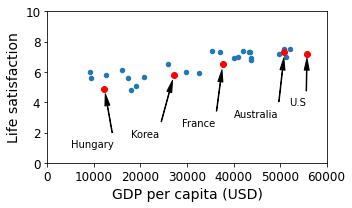

In [69]:
sample_data.plot(kind="scatter", x="GDP per capita", y="Life satisfaction", figsize=(5,3))
plt.axis([0, 60000, 0, 10]) # [xmin=0, xmax=60000, ymin=0, ymax=10]
position_text = {
    "Hungary": (5000, 1), 
    "Korea": (18000, 1.7), 
    "France": (29000, 2.4), 
    "Australia": (40000, 3.0), 
    "United States": (52000, 3.8), 
}

for country, pos_text in position_text.items():
    pos_data_x, pos_data_y = sample_data.loc[country]
    country = "U.S" if country == "United States" else country
    plt.annotate(text=country, xy=(pos_data_x, pos_data_y), xytext=pos_text, 
                 arrowprops=dict(facecolor="black", width=0.5, shrink=0.1, headwidth=5))
    plt.plot(pos_data_x, pos_data_y, "ro")

plt.xlabel("GDP per capita (USD)")
save_fig("money_happiness_scaterplot.png")
plt.show()    

### Save processed data to file

In [71]:
sample_data.to_csv(os.path.join(datapath, "lifesat.csv"))

In [72]:
sample_data.loc[list(position_text.keys())]

,GDP per capita,Life satisfaction
Country,,
Hungary,12239.894,4.9
Korea,27195.197,5.8
France,37675.006,6.5
Australia,50961.865,7.3
United States,55805.204,7.2


### Fitting with different model parameters

Saving figure tweaking_model_params_plot


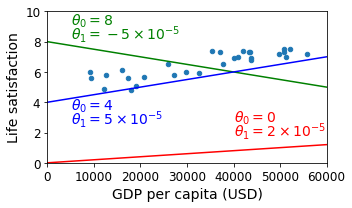

In [75]:
sample_data.plot(kind="scatter", x="GDP per capita", y="Life satisfaction", figsize=(5,3))
plt.xlabel("GDP per capita (USD)")
plt.axis([0, 60000, 0, 10])

X = np.linspace(0, 60000, 10)
# Model 1
plt.plot(X, 2*X/100000, "r")
plt.text(x=40000, y=2.7, s=r"$\theta_0 = 0$", fontsize=14, color="r")
plt.text(x=40000, y=1.8, s=r"$\theta_1 = 2 \times 10^{-5}$", fontsize=14, color="r")
# Model 2
plt.plot(X, 8 - 5*X/100000, "g")
plt.text(x=5000, y=9.1, s=r"$\theta_0 = 8$", fontsize=14, color="g")
plt.text(x=5000, y=8.2, s=r"$\theta_1 = -5 \times 10^{-5}$", fontsize=14, color="g")
# Model 3
plt.plot(X,4 + 5*X/100000, "b")
plt.text(x=5000, y=3.5, s=r"$\theta_0 = 4$", fontsize=14, color="b")
plt.text(x=5000, y=2.6, s=r"$\theta_1 = 5 \times 10^{-5}$", fontsize=14, color="b")

save_fig("tweaking_model_params_plot")
plt.show()